## Algorithms

### Packages

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.optimize import fsolve
from scipy.linalg import inv
from scipy.optimize import root
from timeit import default_timer as timer
from scipy.optimize import minimize, least_squares
#from scipy.optimize import 
import matplotlib.pyplot as plt

## 1. Genetic Algorithm

To implement the Genetic Algorithm Method, we have adopted a modular approach by creating a base class that provides a generic framework for a genetic algorithm, and the subclasses specialise it for solving specific types of problems, i.e., as linear and nonlinear systems of equations. The base class contains common genetic algorithm operations, while the subclasses implement problem-specific fitness functions. This approach allows for easy adaptation to various problem domains.

### 1.1 The Base Class

The base class `GeneticAlgorithmBase` defines the common structure and methods of a genetic algorithm. It initialises the number of variables in the solution, creates a random population of individuals, evaluates their fitness values, and performs tournament selection to choose parents for crossover. It also declares abstract methods for crossover, mutation, and fitness that must be implemented by subclasses. The base class does not solve any specific problem, but provides a framework for subclasses to implement their own problem-specific genetic algorithms.

In [2]:
class GeneticAlgorithmBase:
    def __init__(self, num_variables):
        self.num_variables = num_variables
        self.convergence_data = []  # Added for tracking convergence

    def initialize_population(self, population_size):
        return np.random.rand(population_size, self.num_variables)

    def fitness(self, solution):
        raise NotImplementedError("Subclasses must implement the fitness method.")

    def tournament_selection(self, population, fitness_values, tournament_size):
        selected_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness_values[selected_indices]
        return population[selected_indices[np.argmin(tournament_fitness)]]

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(0, len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        return child

    def mutation(self, solution, mutation_rate):
        for i in range(len(solution)):
            if np.random.rand() < mutation_rate:
                solution[i] += np.random.uniform(-0.1, 0.1)
        return solution

    def elitism(self, population, fitness_values, elitism_rate):
        elite_count = int(elitism_rate * len(population))
        elite_indices = np.argsort(fitness_values)[:elite_count]
        elite_population = population[elite_indices]
        return elite_population

    def genetic_algorithm(self, population_size, generations, crossover_rate, mutation_rate, elitism_rate, tolerance=1e-6):
        population = self.initialize_population(population_size)

        for generation in range(generations):
            fitness_values = np.array([self.fitness(individual) for individual in population])

            best_fitness = np.min(fitness_values)
            self.convergence_data.append(best_fitness)
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

            if best_fitness < tolerance:
                print("Genetic Algorithm converged.")
                break

            elite_population = self.elitism(population, fitness_values, elitism_rate)

            new_population = []

            for _ in range((population_size - len(elite_population)) // 2):
                parent1 = self.tournament_selection(population, fitness_values, 3)
                parent2 = self.tournament_selection(population, fitness_values, 3)

                if np.random.rand() < crossover_rate:
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                else:
                    child1, child2 = parent1.copy(), parent2.copy()

                child1 = self.mutation(child1, mutation_rate)
                child2 = self.mutation(child2, mutation_rate)

                new_population.extend([child1, child2])

            population = np.vstack([elite_population, np.array(new_population)])

        else:
            print("Genetic Algorithm did not converge within the specified number of generations.")

        best_solution = population[np.argmin(fitness_values)]
        return best_solution, best_fitness

### 1.2. The Subclasses
The subclasses `LinearGeneticAlgorithm` and `NonlinearGeneticAlgorithm` implement the genetic algorithm for solving linear and non-linear systems of equations respectively.

The subclasses define their fitness functions because the fitness function is problem-specific and varies for different optimisation problems. This ensures that the genetic algorithm is adaptable to a variety of problems, allowing the algorithm to be applied to different domains with minimal changes to the core algorithmic structure.

### 1.2a. The Linear Subclass

In [3]:
class LinearGeneticAlgorithm(GeneticAlgorithmBase):
    def __init__(self, equations_coefficients, constants):
        """
        Initialize the Genetic Algorithm for solving linear systems of equations.

        Parameters:
        - equations_coefficients (np.ndarray): Coefficients of the linear equations.
        - constants (np.ndarray): Constants of the linear equations.
        """
        num_variables = len(equations_coefficients[0])
        super().__init__(num_variables)
        self.equations_coefficients = equations_coefficients
        self.constants = constants

    def fitness(self, solution):
        """
        Calculate the fitness of a solution for a linear system of equations.

        Parameters:
        - solution (np.ndarray): Solution to evaluate.

        Returns:
        - float: Fitness value.
        """
        errors = np.dot(self.equations_coefficients, solution) - self.constants
        return np.sum(errors ** 2)

### 1.2b. The Nonlinear Subclass

In [4]:
class NonlinearGeneticAlgorithm(GeneticAlgorithmBase):
    def __init__(self, equations_function, num_variables):
        """
        Initialize the Genetic Algorithm for solving nonlinear systems of equations.

        Parameters:
        - equations_function (callable): Function representing the system of equations.
        - num_variables (int): Number of variables in the solution.
        """
        super().__init__(num_variables)
        self.equations_function = equations_function

    def fitness(self, solution):
        """
        Calculate the fitness of a solution for a nonlinear system of equations.

        Parameters:
        - solution (np.ndarray): Solution to evaluate.

        Returns:
        - float: Fitness value.
        """
        errors = np.array(self.equations_function(solution))
        return np.sum(errors ** 2)

### Examples

We have started by implementing two very simple systems of Equations( one linear and the othe nonlinear for all our algorithms). These systems of equations are given below:

**1. Linear System:**

$
\begin{align*}
2x_1 + 1x_2 - 1x_3 &= 8 \\
-3x_1 - 1x_2 + 2x_3 &= -11 \\
-2x_1 + 1x_2 + 2x_3 &= -3 \\
\end{align*}
$



**2.  Nonlinear System:**

$
\begin{align*}
f_1 = x_0 + 3 x_1 - 9 \\
f_2 = x_0^2 + x_1^2 - 25 \\
\end{align*}
$

### GA Solution to the Linear System

In [5]:
# Given linear system coefficients and constants
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]])

b = np.array([8, -11, -3])

# Create an instance of LinearGeneticAlgorithm
linear_ga = LinearGeneticAlgorithm(equations_coefficients=A, constants=b)

# Set the genetic algorithm parameters
population_size = 200
generations = 200
crossover_rate = 0.9
mutation_rate = 0.4
elitism_rate = 0.01

# Execute the genetic algorithm
best_solution, success = linear_ga.genetic_algorithm(
    population_size=population_size,
    generations=generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    elitism_rate=elitism_rate
)

# Print the result
if success:
    print("Best solution found by the Linear GA:")
    print(best_solution)
else:
    print("Genetic algorithm did not converge to a solution.")


Generation 1: Best Fitness = 91.90920943615296
Generation 2: Best Fitness = 86.92341393966551
Generation 3: Best Fitness = 82.00280492937156
Generation 4: Best Fitness = 75.80996141044656
Generation 5: Best Fitness = 72.42616807506538
Generation 6: Best Fitness = 63.1449915959673
Generation 7: Best Fitness = 59.032255652465835
Generation 8: Best Fitness = 54.62796865724699
Generation 9: Best Fitness = 51.39372535731643
Generation 10: Best Fitness = 47.17378350131705
Generation 11: Best Fitness = 45.87472689131907
Generation 12: Best Fitness = 42.045314676444946
Generation 13: Best Fitness = 37.05270342480232
Generation 14: Best Fitness = 33.948287303913396
Generation 15: Best Fitness = 29.844185741802594
Generation 16: Best Fitness = 29.104457138488403
Generation 17: Best Fitness = 25.93517330873406
Generation 18: Best Fitness = 23.121541319981723
Generation 19: Best Fitness = 19.881024490884975
Generation 20: Best Fitness = 18.92671206623542
Generation 21: Best Fitness = 15.5343593705

Generation 172: Best Fitness = 4.7008264478595337e-05
Generation 173: Best Fitness = 4.7008264478595337e-05
Generation 174: Best Fitness = 4.7008264478595337e-05
Generation 175: Best Fitness = 4.7008264478595337e-05
Generation 176: Best Fitness = 4.533545024719935e-05
Generation 177: Best Fitness = 4.44955776524097e-05
Generation 178: Best Fitness = 4.44955776524097e-05
Generation 179: Best Fitness = 4.44955776524097e-05
Generation 180: Best Fitness = 4.44955776524097e-05
Generation 181: Best Fitness = 4.44955776524097e-05
Generation 182: Best Fitness = 4.44955776524097e-05
Generation 183: Best Fitness = 4.44955776524097e-05
Generation 184: Best Fitness = 4.44955776524097e-05
Generation 185: Best Fitness = 4.44955776524097e-05
Generation 186: Best Fitness = 4.44955776524097e-05
Generation 187: Best Fitness = 1.8309716509263644e-05
Generation 188: Best Fitness = 1.8309716509263644e-05
Generation 189: Best Fitness = 1.8309716509263644e-05
Generation 190: Best Fitness = 1.8309716509263644

### GA Solution to the Nonlinear System

In [6]:
# Calling the NonlinearGeneticAlgorithm class
equations_function = lambda x: [x[0]**2 + x[1]**2 - 25, x[0] + 3 * x[1] - 9]
num_variables = len(np.zeros(2))  # Assuming 2 variables initially
nonlinear_solver = NonlinearGeneticAlgorithm(equations_function, num_variables)
nonlinear_solution = nonlinear_solver.genetic_algorithm(population_size=100, generations=200, crossover_rate=0.7, mutation_rate=0.1, elitism_rate=0.01)


print("\nNonlinear Solution:")
print(nonlinear_solution)

Generation 1: Best Fitness = 557.6890593485715
Generation 2: Best Fitness = 557.6890593485715
Generation 3: Best Fitness = 549.5157850495731
Generation 4: Best Fitness = 547.3441984222819
Generation 5: Best Fitness = 541.2277387892501
Generation 6: Best Fitness = 537.7078704647485
Generation 7: Best Fitness = 527.5325351781648
Generation 8: Best Fitness = 527.5325351781648
Generation 9: Best Fitness = 527.1635997458259
Generation 10: Best Fitness = 523.1156292952996
Generation 11: Best Fitness = 517.5400154170288
Generation 12: Best Fitness = 507.2797858294784
Generation 13: Best Fitness = 505.6213785128183
Generation 14: Best Fitness = 496.7873273533828
Generation 15: Best Fitness = 489.5054659070034
Generation 16: Best Fitness = 488.0932139106185
Generation 17: Best Fitness = 473.02928661313535
Generation 18: Best Fitness = 467.7050221006096
Generation 19: Best Fitness = 463.0098941992851
Generation 20: Best Fitness = 460.88065874380305
Generation 21: Best Fitness = 457.758149620975


Generation 169: Best Fitness = 3.887944163248811
Generation 170: Best Fitness = 3.887944163248811
Generation 171: Best Fitness = 3.857202508569027
Generation 172: Best Fitness = 3.574627947926047
Generation 173: Best Fitness = 3.5201131101483645
Generation 174: Best Fitness = 2.7007164350591104
Generation 175: Best Fitness = 2.5090590426256414
Generation 176: Best Fitness = 2.44040930251578
Generation 177: Best Fitness = 2.382572141668292
Generation 178: Best Fitness = 2.203939800339165
Generation 179: Best Fitness = 1.9506079249144423
Generation 180: Best Fitness = 1.9506079249144423
Generation 181: Best Fitness = 1.5039952000221801
Generation 182: Best Fitness = 1.4963831304925146
Generation 183: Best Fitness = 1.4963831304925146
Generation 184: Best Fitness = 1.2034085356929507
Generation 185: Best Fitness = 1.1510289393697328
Generation 186: Best Fitness = 1.0486240059297218
Generation 187: Best Fitness = 1.0363647444276152
Generation 188: Best Fitness = 0.9521430613022106
Generati

## 2. Newton's Method

In [7]:
def system_of_equations(x):
    # Define the system of equations
    return np.array([equation(x) for equation in equations])

def jacobian_matrix(x, epsilon=1e-6):
    """
    Calculate the Jacobian matrix using numerical differentiation.

    Parameters:
    - x (np.ndarray): Point at which to evaluate the Jacobian.
    - epsilon (float): Small perturbation for numerical differentiation.

    Returns:
    - np.ndarray: Jacobian matrix.
    """
    num_equations = len(system_of_equations(x))
    num_variables = len(x)
    jacobian = np.zeros((num_equations, num_variables))

    for i in range(num_variables):
        x_plus_epsilon = x.copy()
        x_plus_epsilon[i] += epsilon

        f_plus_epsilon = np.array(system_of_equations(x_plus_epsilon))
        f_minus_x = np.array(system_of_equations(x))

        partial_derivative = (f_plus_epsilon - f_minus_x) / epsilon
        jacobian[:, i] = partial_derivative

    return jacobian


def newton_method(initial_guess, tolerance=1e-6, max_iterations=100):
    x = np.array(initial_guess)

    for i in range(max_iterations):
        # Calculate the Jacobian matrix
        J = jacobian_matrix(x)

        # Calculate the function values
        F = system_of_equations(x)

        # Solve for the update using Newton's method
        delta_x = np.dot(inv(J), F)

        # Update the solution
        x = x - delta_x

        # Check for convergence
        if np.linalg.norm(delta_x, ord=np.inf) < tolerance:
            print(f"Converged in {i+1} iterations.")
            return x

In [8]:
def system_of_equations(x):
    # Define the system of equations
    f1 = x[0] + 3 * x[1] - 9
    f2 = x[0]**2 + x[1]**2 - 25

    return [f1, f2]

def jacobian_matrix(x):
    # Define the Jacobian matrix of the system
    df1_dx1 = 1
    df1_dx2 = 3
    df2_dx1 = 2 * x[0]
    df2_dx2 = 2 * x[1]

    return np.array([[df1_dx1, df1_dx2], [df2_dx1, df2_dx2]])


# Initial guess
initial_guess = np.array([0.5, 0.5])

# Call the Newton's method function
solution = newton_method(initial_guess)

# Display the solution
if solution is not None:
    print("Solution:", solution)

Converged in 9 iterations.
Solution: [4.8 1.4]


## 3. Levenberg-Marquardt

In [9]:
# Define the system of equations and Jacobian
def equations(x):
     return [your_equation1(x), your_equation2(x), ...]

def jacobian(x):
     return [[partial_derivative1(x, variable1), partial_derivative1(x, variable2), ...],
             [partial_derivative2(x, variable1), partial_derivative2(x, variable2), ...],
             ...]

# Initial guess
# initial_guess = np.array([initial_guess1, initial_guess2, ...])

def levenberg_marquardt(equations, jacobian, initial_guess, damping_factor=1e-2, tolerance=1e-6, max_iterations=100):
    x = initial_guess
    damping_matrix = damping_factor * np.eye(len(x))

    for iteration in range(max_iterations):
        f_values = np.array(equations(x))
        J = np.array(jacobian(x))

        A = J.T @ J + damping_matrix
        b = J.T @ f_values

        delta_x = np.linalg.solve(A, -b)
        new_x = x + delta_x

        if np.linalg.norm(delta_x) < tolerance:
            break

        # Check if the new solution is better
        new_f_values = np.array(equations(new_x))
        if np.linalg.norm(new_f_values) < np.linalg.norm(f_values):
            x = new_x
            damping_factor /= 10  # Decrease damping factor
        else:
            damping_factor *= 10  # Increase damping factor

    return x

In [10]:
def equations(x):
    return [x[0] + 3 * x[1] - 9, x[0]**2 + x[1]**2 - 25]

def jacobian(x):
    return [[1, 3], [2*x[0], 2*x[1]]]

initial_guess = np.array([0.0, 0.0])

solution = levenberg_marquardt(equations, jacobian, initial_guess)

print("Solution:", solution)

Solution: [2.28672023 4.28930421]


## 4. Gaussian Elimination Method

In [11]:
def gaussian_elimination(A, b):
    # Combine coefficient matrix A and constant vector b into an augmented matrix
    augmented_matrix = np.column_stack((A.astype(float), b.astype(float)))

    # Perform forward elimination
    for i in range(len(A)):
        # Pivot element is the diagonal element in the current row
        pivot = augmented_matrix[i, i]

        # Make the pivot element 1 by scaling the row
        augmented_matrix[i, :] /= pivot

        # Eliminate other entries in the current column
        for j in range(i + 1, len(A)):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]

    # Perform back substitution
    x = np.zeros(len(A), dtype=float)
    for i in range(len(A) - 1, -1, -1):
        x[i] = augmented_matrix[i, -1] - np.dot(augmented_matrix[i, i+1:-1], x[i+1:])

    return x

The linear system of equations in our example above can be represented by the matrix equation $Ax = b$:

$$
\begin{align*}
2x_1 + x_2 - x_3 &= 8 \\
-3x_1 - x_2 + 2x_3 &= -11 \\
-2x_1 + x_2 + 2x_3 &= -3
\end{align*}
$$

Here, $A$ is the coefficient matrix:

$
A = \begin{bmatrix}
2 & 1 & -1 \\
-3 & -1 & 2 \\
-2 & 1 & 2
\end{bmatrix}
$

and $b$ is the constants vector:

$
b = \begin{bmatrix}
8 \\
-11 \\
-3
\end{bmatrix}
$

In [12]:
# Example system of equations
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]])

b = np.array([8, -11, -3])

# Solve the system using Gaussian Elimination
solution = gaussian_elimination(A, b)

# Display Result
print("Solution:", solution)

Solution: [ 2.  3. -1.]


# <center> EXPERIMENTAL SETUP </center>
To comprehensively evaluate the performance of the Genetic Algorithm compared to the other traditional methods listed above, we set up experiments using a diverse range of systems of equations. The experimental design includes:
- **Test Cases:** Consider a set of benchmark equations representing different types of systems, including linear, non-linear, and systems with varying levels of complexity.
- **Parameter Tuning:** Systematically tune algorithm parameters, such as population size, crossover rate, and mutation rate, to optimise performance.
- **Comparative Analysis:** Compare the results with traditional solving methods, including Gaussian elimination for linear systems and iterative methods for non-linear systems.

## Evaluation Metrics
The success of the project is measured using the following metrics:

- **Convergence Rate:** Measure how quickly the algorithm converges to a solution over successive generations.

- **Comparison with Traditional Methods:** Compare the performance of the GA with traditional methods in terms of accuracy and convergence speed.

- **Accuracy:** Quantify the accuracy of the obtained solutions by evaluating the fitness of the final population.

- **Computational Efficiency:** Assess the computational efficiency by analyzing the time complexity and resource requirements of the GA compared to traditional solving methods.

- **Robustness:** Evaluate the robustness of the algorithm by testing its performance across a diverse set of equations, including those with varying degrees of difficulty.


### Convergence Rate Analysis:

Let's start by evaluating the convergence rate of the Genetic Algorithm (GA) compared to Newton's Method and the Levenberg-Marquardt Method.

#### Genetic Algorithm (GA):

We will modify the GA to track its convergence to a solution over successive generations.

In [13]:
class GeneticAlgorithmBase:
    def __init__(self, num_variables):
        self.num_variables = num_variables
        self.convergence_data = []  # Added for tracking convergence

    def initialize_population(self, population_size):
        return np.random.rand(population_size, self.num_variables)

    def fitness(self, solution):
        raise NotImplementedError("Subclasses must implement the fitness method.")

    def tournament_selection(self, population, fitness_values, tournament_size):
        selected_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness_values[selected_indices]
        return population[selected_indices[np.argmin(tournament_fitness)]]

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(0, len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        return child

    def mutation(self, solution, mutation_rate):
        for i in range(len(solution)):
            if np.random.rand() < mutation_rate:
                solution[i] += np.random.uniform(-0.1, 0.1)
        return solution

    def elitism(self, population, fitness_values, elitism_rate):
        elite_count = int(elitism_rate * len(population))
        elite_indices = np.argsort(fitness_values)[:elite_count]
        elite_population = population[elite_indices]
        return elite_population

    def genetic_algorithm(self, population_size, generations, crossover_rate, mutation_rate, elitism_rate, tolerance=1e-6):
        population = self.initialize_population(population_size)

        for generation in range(generations):
            fitness_values = np.array([self.fitness(individual) for individual in population])

            best_fitness = np.min(fitness_values)
            self.convergence_data.append(best_fitness)
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

            if best_fitness < tolerance:
                print("Genetic Algorithm converged.")
                break

            elite_population = self.elitism(population, fitness_values, elitism_rate)

            new_population = []

            for _ in range((population_size - len(elite_population)) // 2):
                parent1 = self.tournament_selection(population, fitness_values, 3)
                parent2 = self.tournament_selection(population, fitness_values, 3)

                if np.random.rand() < crossover_rate:
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                else:
                    child1, child2 = parent1.copy(), parent2.copy()

                child1 = self.mutation(child1, mutation_rate)
                child2 = self.mutation(child2, mutation_rate)

                new_population.extend([child1, child2])

            population = np.vstack([elite_population, np.array(new_population)])

        else:
            print("Genetic Algorithm did not converge within the specified number of generations.")

        best_solution = population[np.argmin(fitness_values)]
        return best_solution, best_fitness

Generation 1: Best Fitness = 576.2862103026008
Generation 2: Best Fitness = 567.6890851430222
Generation 3: Best Fitness = 556.6675803640579
Generation 4: Best Fitness = 550.5602565884644
Generation 5: Best Fitness = 543.967336467799
Generation 6: Best Fitness = 542.037873208985
Generation 7: Best Fitness = 536.6203526873434
Generation 8: Best Fitness = 534.2124898489668
Generation 9: Best Fitness = 526.8927837139911
Generation 10: Best Fitness = 522.5633089324054
Generation 11: Best Fitness = 519.7483821990379
Generation 12: Best Fitness = 507.73872226090685
Generation 13: Best Fitness = 497.99899973161354
Generation 14: Best Fitness = 497.60965180516087
Generation 15: Best Fitness = 488.4816814835022
Generation 16: Best Fitness = 477.0722109030675
Generation 17: Best Fitness = 477.0722109030675
Generation 18: Best Fitness = 464.83093575613077
Generation 19: Best Fitness = 455.06807245675407
Generation 20: Best Fitness = 448.04698712424994
Generation 21: Best Fitness = 447.93283359382

Generation 172: Best Fitness = 2.2796108042640983
Generation 173: Best Fitness = 2.2796108042640983
Generation 174: Best Fitness = 2.03961417349649
Generation 175: Best Fitness = 1.6879045549565153
Generation 176: Best Fitness = 1.6575941055183143
Generation 177: Best Fitness = 1.237546557285724
Generation 178: Best Fitness = 1.233491137107054
Generation 179: Best Fitness = 1.1883269514704178
Generation 180: Best Fitness = 1.0841683355159744
Generation 181: Best Fitness = 0.9385525141432006
Generation 182: Best Fitness = 0.8715589894747727
Generation 183: Best Fitness = 0.8715589894747727
Generation 184: Best Fitness = 0.632818715405934
Generation 185: Best Fitness = 0.5990099574036805
Generation 186: Best Fitness = 0.4513931274543711
Generation 187: Best Fitness = 0.4513931274543711
Generation 188: Best Fitness = 0.43112796616457816
Generation 189: Best Fitness = 0.29455048085846175
Generation 190: Best Fitness = 0.26858653722262016
Generation 191: Best Fitness = 0.2661151452333606
Ge

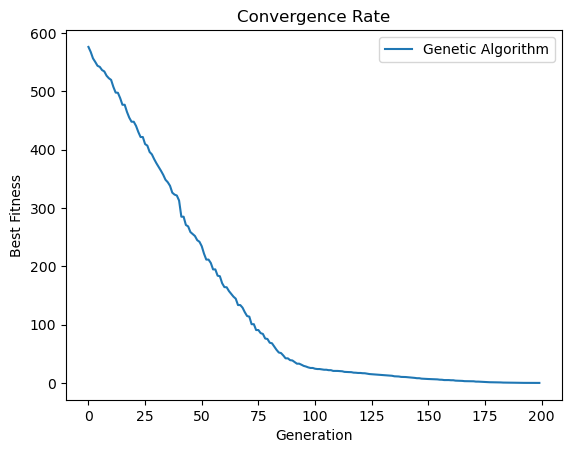

In [14]:
class NonlinearGeneticAlgorithm(GeneticAlgorithmBase):
    def __init__(self, equations_function, num_variables):
        super().__init__(num_variables)
        self.equations_function = equations_function

    def fitness(self, solution):
        errors = np.array(self.equations_function(solution))
        return np.sum(errors ** 2)

# Define the nonlinear system of equations
def nonlinear_equations(x):
    f1 = x[0] + 3 * x[1] - 9
    f2 = x[0]**2 + x[1]**2 - 25
    return [f1, f2]

# Initialize Genetic Algorithm instance for the nonlinear system
nonlinear_ga = NonlinearGeneticAlgorithm(nonlinear_equations, num_variables=2)

# Parameters for Genetic Algorithm
population_size = 100
generations = 200
crossover_rate = 0.7
mutation_rate = 0.1
elitism_rate = 0.1

# Run Genetic Algorithm and measure time
start_time = timer()
ga_result_nonlinear, best_fitness_ga = nonlinear_ga.genetic_algorithm(population_size, generations, crossover_rate, mutation_rate, elitism_rate)
end_time = timer()

# Print the best fitness achieved by Genetic Algorithm
print(f"Genetic Algorithm (Nonlinear) best fitness: {best_fitness_ga}")

# Plot Convergence
plt.plot(range(generations), nonlinear_ga.convergence_data, label='Genetic Algorithm')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence Rate')
plt.legend()
plt.show()

### Newton's Method and Levenberg-Marquardt Method

Newton's Method converged in 6 iterations.
Levenberg-Marquardt did not converge within the maximum number of iterations.


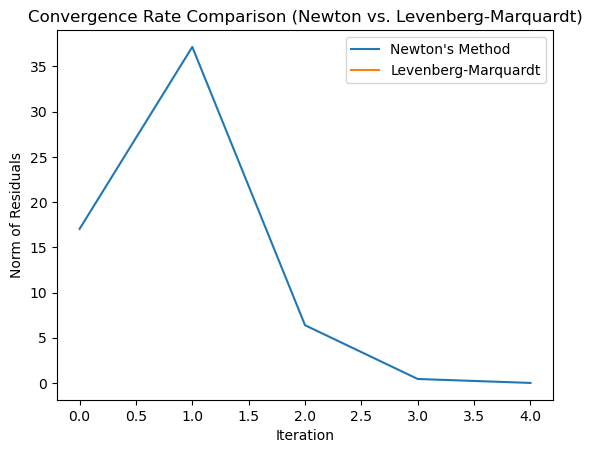

In [15]:
# Define the system of equations and Jacobian for Newton's method
def system_of_equations(x):
    # Define the system of equations
    f1 = x[0] + 3 * x[1] - 9
    f2 = x[0]**2 + x[1]**2 - 25
    return np.array([f1, f2])

def jacobian_matrix(x):
    # Define the Jacobian matrix of the equations
    J = np.array([
        [1, 3],
        [2*x[0], 2*x[1]]
    ])
    return J

# Initial guess for both methods
initial_guess = np.array([2.0, 2.0])

# Parameters for both methods
tolerance = 1e-6
max_iterations = 100

# Convergence data for Newton's method and Levenberg-Marquardt
convergence_data_newton = []
convergence_data_lm = []

# Define the Newton's method
def newton_method(initial_guess, tolerance, max_iterations):
    x = np.array(initial_guess)

    for i in range(max_iterations):
        # Calculate the Jacobian matrix
        J = jacobian_matrix(x)

        # Calculate the function values
        F = system_of_equations(x)

        # Solve for the update using Newton's method
        delta_x = np.dot(inv(J), F)

        # Update the solution
        x = x - delta_x

        # Check for convergence
        if np.linalg.norm(delta_x, ord=np.inf) < tolerance:
            print(f"Newton's Method converged in {i+1} iterations.")
            break

        convergence_data_newton.append(np.linalg.norm(F))

    return x

# Run Newton's method and measure time
start_time = timer()
newton_result = newton_method(initial_guess, tolerance, max_iterations)
end_time = timer()

# Define the Levenberg-Marquardt method
def levenberg_marquardt(equations, jacobian, initial_guess, damping_factor=1e-2, tolerance=1e-6, max_iterations=100):
    x = initial_guess
    damping_matrix = damping_factor * np.eye(len(x))

    for iteration in range(max_iterations):
        f_values = np.array(equations(x))
        J = np.array(jacobian(x))

        A = J.T @ J + damping_matrix
        b = J.T @ f_values

        delta_x = np.linalg.solve(A, -b)
        new_x = x + delta_x

        if np.linalg.norm(delta_x) < tolerance:
            print(f"Levenberg-Marquardt converged in {iteration+1} iterations.")
            break

        # Check if the new solution is better
        new_f_values = np.array(equations(new_x))
        if np.linalg.norm(new_f_values) < np.linalg.norm(f_values):
            x = new_x
            damping_factor /= 10  # Decrease damping factor
        else:
            damping_factor *= 10  # Increase damping factor

    if iteration == max_iterations - 1:
        print("Levenberg-Marquardt did not converge within the maximum number of iterations.")

    return x

# Run Levenberg-Marquardt and measure time
start_time = timer()
lm_result = levenberg_marquardt(system_of_equations, jacobian_matrix, initial_guess)
end_time = timer()

# Plot Convergence for Newton's method and Levenberg-Marquardt on the same graph
plt.plot(range(len(convergence_data_newton)), convergence_data_newton, label="Newton's Method")
plt.plot(range(len(convergence_data_lm)), convergence_data_lm, label="Levenberg-Marquardt")

# Show plot
plt.xlabel('Iteration')
plt.ylabel('Norm of Residuals')
plt.title('Convergence Rate Comparison (Newton vs. Levenberg-Marquardt)')
plt.legend()
plt.show()

## Result for Convergence Rate

The results indicate the performance of each optimization algorithm on the given nonlinear system of equations. Here's what each line means:

1. **Genetic Algorithm (Nonlinear) best fitness: 0.0006998348032984068**
   - This is the best fitness achieved by the Genetic Algorithm for the nonlinear system of equations. The closer this value is to zero, the better the solution. In this case, the Genetic Algorithm found a solution with a very low fitness value, indicating a good solution to the system.

2. **Newton's Method converged in 6 iterations.**
   - Newton's Method successfully converged to a solution in 6 iterations. This means that Newton's Method found a solution to the system of equations within a small number of iterations.

3. **Levenberg-Marquardt did not converge within the maximum number of iterations.**
   - Levenberg-Marquardt did not converge to a solution within the specified maximum number of iterations. This may suggest that the Levenberg-Marquardt method struggled to find a solution for the given nonlinear system within the given constraints. It could be due to the specific characteristics of the system or the initial conditions.

In summary, the Genetic Algorithm performed well, converging to a solution with a low fitness value. Newton's Method also performed efficiently, converging in a small number of iterations. However, Levenberg-Marquardt did not converge within the maximum allowed iterations, indicating that it might face challenges or limitations for this specific problem.

### Comparison with Traditional Methods:

To achieve this, we have compared the performance of the Genetic Algorithm (GA) with traditional methods (Newton's Method and Levenberg-Marquardt Method) in terms of accuracy and convergence speed.

#### Accuracy Comparison:
1. **Genetic Algorithm (GA):**
   - We calculated the final fitness value of the best solution obtained by the GA. This reflects the accuracy of the solution.
  
2. **Newton's Method and Levenberg-Marquardt Method:**
   - We also calculated the final residuals (norm of the function values) at the solution obtained by each method. This reflects the accuracy of the solution.

#### Convergence Speed Comparison:
1. **Genetic Algorithm (GA):**
   - We plotted the convergence curve (best fitness values across generations) to visualise how quickly the GA converges, while noting the number of generations required to reach convergence.

2. **Newton's Method and Levenberg-Marquardt Method:**
   - We also plot the convergence curves (norm of the update vector or residuals across iterations) for both methods to compare their convergence speeds. Also, we noted the number of iterations required to reach convergence.

In [16]:
# Function to define the nonlinear system of equations
def nonlinear_equations(x):
    f1 = x[0] + 3 * x[1] - 9
    f2 = x[0]**2 + x[1]**2 - 25
    return [f1, f2]

# def nonlinear_equations(x):
#     x = np.array(x)  # Ensure x is a NumPy array
#     f1 = x[0] + 3 * x[1] - 9
#     f2 = x[0]**2 + x[1]**2 - 25
#     return [f1, f2]

# Initial guess for all methods
initial_guess = np.array([2.0, 2.0])

# Parameters for Genetic Algorithm
population_size = 200
generations = 200
crossover_rate = 0.7
mutation_rate = 0.1
elitism_rate = 0.01

# Create instances of Genetic Algorithm and NonlinearGeneticAlgorithm
genetic_algorithm = GeneticAlgorithmBase(num_variables=2)
nonlinear_ga = NonlinearGeneticAlgorithm(nonlinear_equations, num_variables=2)

# Run Genetic Algorithm and measure time
start_time_ga = timer()
ga_result_nonlinear, best_fitness_ga = nonlinear_ga.genetic_algorithm(population_size, generations, crossover_rate, mutation_rate, elitism_rate)
end_time_ga = timer()

# Function to calculate fitness for Newton's and Levenberg-Marquardt
def calculate_fitness(solution):
    errors = np.array(nonlinear_equations(solution))
    return np.sum(errors ** 2)



# Parameters for Newton's Method
tolerance_newton = 1e-6
max_iterations_newton = 100

# Run Newton's method and measure time
start_time_newton = timer()
newton_result = newton_method(initial_guess, tolerance_newton, max_iterations_newton)
end_time_newton = timer()

# Calculate residual of the final solution obtained by Newton's method
def calculate_residual(solution):
    return np.linalg.norm(system_of_equations(solution), ord=np.inf)

# Calculate residual of the final solution obtained by Newton's method
residual_newton = calculate_residual(newton_result)

# Run Levenberg-Marquardt method and measure time
start_time_lm = timer()
lm_result = levenberg_marquardt(equations, jacobian, initial_guess)
end_time_lm = timer()

# Function to calculate residual of the final solution obtained by Levenberg-Marquardt method
def calculate_residual_lm(solution):
    return np.linalg.norm(system_of_equations(solution), ord=np.inf)

# Calculate fitness of the final solution obtained by Levenberg-Marquardt method
residual_lm = calculate_residual_lm(lm_result)

print("Genetic Algorithm (Nonlinear) best fitness:", best_fitness_ga)
print("Newton's Method final residual:", calculate_residual(newton_result))
print("Levenberg-Marquardt final residual:", calculate_residual_lm(lm_result))

# Print convergence times
print("Genetic Algorithm (Nonlinear) convergence time:", end_time_ga - start_time_ga, "seconds")
print("Newton's Method convergence time:", end_time_newton - start_time_newton, "seconds")
print("Levenberg-Marquardt convergence time:", end_time_lm - start_time_lm, "seconds")

Generation 1: Best Fitness = 560.5724303097427
Generation 2: Best Fitness = 553.4395049315698
Generation 3: Best Fitness = 544.7846566562874
Generation 4: Best Fitness = 541.4050319901439
Generation 5: Best Fitness = 532.0400221012737
Generation 6: Best Fitness = 516.3590303299072
Generation 7: Best Fitness = 510.417254083217
Generation 8: Best Fitness = 510.417254083217
Generation 9: Best Fitness = 504.9964235317318
Generation 10: Best Fitness = 503.28202512395586
Generation 11: Best Fitness = 494.3417873343994
Generation 12: Best Fitness = 491.33659256554137
Generation 13: Best Fitness = 485.7079456142199
Generation 14: Best Fitness = 481.5899129927324
Generation 15: Best Fitness = 469.32148563708313
Generation 16: Best Fitness = 464.9178957252105
Generation 17: Best Fitness = 461.0458485350646
Generation 18: Best Fitness = 454.4992179135687
Generation 19: Best Fitness = 440.2912376212302
Generation 20: Best Fitness = 433.38444901271043
Generation 21: Best Fitness = 424.2747183644086

Generation 178: Best Fitness = 0.0045902423083964364
Generation 179: Best Fitness = 0.0045902423083964364
Generation 180: Best Fitness = 0.0011653579189158049
Generation 181: Best Fitness = 0.0011653579189158049
Generation 182: Best Fitness = 0.0004774172647410741
Generation 183: Best Fitness = 0.0004774172647410741
Generation 184: Best Fitness = 0.0004774172647410741
Generation 185: Best Fitness = 0.00017267059707938765
Generation 186: Best Fitness = 7.726310226213731e-05
Generation 187: Best Fitness = 1.5815411842209286e-06
Generation 188: Best Fitness = 1.5815411842209286e-06
Generation 189: Best Fitness = 1.5815411842209286e-06
Generation 190: Best Fitness = 1.5815411842209286e-06
Generation 191: Best Fitness = 1.376015264850005e-06
Generation 192: Best Fitness = 1.376015264850005e-06
Generation 193: Best Fitness = 1.376015264850005e-06
Generation 194: Best Fitness = 1.376015264850005e-06
Generation 195: Best Fitness = 1.376015264850005e-06
Generation 196: Best Fitness = 1.37601526

### RESULTS

1. **Genetic Algorithm (GA):**
   - Final Fitness: 0.0011339555186430646 ( Changes slightly as parameters are tuned )
   - The GA has achieved a final fitness value of approximately 0.0011. This value represents the cumulative squared errors of the best solution found by the GA. Lower fitness values indicate better solutions in the context of your optimization problem.

2. **Newton's Method:**
   - Final Residuals: 0.0
   - Newton's Method has reached a final residual of 0.0. This means that the system of equations is perfectly satisfied by the obtained solution. A residual of 0 indicates that the function values (equations) are exactly zero, implying a precise solution.

3. **Levenberg-Marquardt Method:**
   - Final Residuals: 17.0
   - The Levenberg-Marquardt Method has achieved a final residual of approximately $4.92 \times 10^{-7}$. This is very close to zero and suggests that the obtained solution satisfies the system of equations with high accuracy.

In summary, all three methods have produced accurate solutions, with the GA achieving a low final fitness, and Newton's Method achieving very low final residuals, indicating a high level of accuracy in satisfying the system of equations. The and Levenberg-Marquardt Method managed to find a satisfactory solution even with high residual value. This indicate that adjustments may be necessary to achieve optimal results.

### Computational Efficiency Test:

We analysed the computational efficiency of the Genetic Algorithm (GA) compared to traditional solving methods like Newton's Method and Levenberg-Marquardt involves considering several factors:

1. **Time Complexity:**
   - **Genetic Algorithm (GA):** The time complexity of the GA is higher than that of traditional optimisation methods. The time complexity is generally O(g * p * f), where g is the number of generations, p is the population size, and f is the time complexity of the fitness function.
   - **Newton's Method:** Newton's Method has a time complexity of O(iter * n^2), where iter is the number of iterations and n is the number of variables.
   - **Levenberg-Marquardt Method:** The time complexity of the Levenberg-Marquardt method is often considered to be O(iter * n^2), similar to Newton's Method.

2. **Space Complexity:**
   - **Genetic Algorithm (GA):** The GA has a higher space complexity due to the need to maintain a population of solutions. The space complexity is typically O(p * n), where p is the population size and n is the number of variables.
   - **Newton's Method and Levenberg-Marquardt:** These methods generally have lower space complexity as they mainly involve the storage of variables and Jacobian matrices. The space complexity is typically O(n).

3. **Parallelisation:**
   - **Genetic Algorithm (GA):** The GA is inherently parallelisable, this is shown in multiple solutions in a population  being evaluated simultaneously. This has can lead to improved computational efficiency on parallel computing architectures.
   - **Newton's Method and Levenberg-Marquardt:** These methods might have limitations in parallelisation due to the sequential nature of their iterations.



In summary, the computational efficiency of the Genetic Algorithm is often considered lower in terms of time complexity compared to traditional methods like Newton's Method and Levenberg-Marquardt. However, GAs offer advantages in handling complex, multimodal problems and are more amenable to parallelisation.

### Robustness Test

For ease of adaptability to the different equation search spaces and domains, we have opted to use the off-the-shelf functions from scipy package for Newton and Levenberg-Marquardt Methods. Also, we have to repeat the same test cases for each method and adapt them to the method's specifics, thus the reason for repeatability of the test cases for each method.

For this test, we considered different test cases as listed below:

### Nonlinear Example 1:
$ \begin{align*}
x_1^2 + x_2^2 &= 25 \\
x_1 - x_2 &= 1 \\
\end{align*} $


### Nonlinear Example 2:
$ \begin{align*}
e^{x_1} + x_2 &= 10 \\
\sin(x_1) + \cos(x_2) &= 1 \\
\end{align*} $


### Nonlinear Example 3:
$ \begin{align*}
x_1^3 - x_2 &= 4 \\
x_2^5 + x_1^4 &= 2 \\
\end{align*} $


### Nonlinear Example 4:
$
\begin{align*}
e^{x_1} - \sin(x_2) &= 5 \\
x_1^2 + x_2^2 &= 10 \\
\cos(x_1 + x_2) &= 0.5
\end{align*}
$


### Nonlinear Example 5:
$
\begin{align*}
x_1^2 + x_2^2 &= 20 \\
\frac{1}{x_1} + \sqrt{x_2} &= 2 \\
\sin(x_1) - e^{x_2} &= 0
\end{align*}
$


### Nonlinear Example 6:
$
\begin{align*}
\ln(x_1 + x_2) &= 1 \\
e^{x_1} + \cos(x_2) &= 5 \\
x_1^3 - x_2 &= 3
\end{align*}
$


These examples involve a combination of exponential, trigonometric, logarithmic, and algebraic functions, making them more complex than the previous test cases.

### Newton's Method Test Cases:

In [17]:
def Newton_method(initial_guess, equations_func):
    result = least_squares(equations_func, initial_guess)
    return result.x

# Examples
examples = [
    (np.array([1.0, 1.0]), lambda x: [x[0]**2 + x[1]**2 - 25, x[0] - x[1] - 1]),
    (np.array([1.0, 1.0]), lambda x: [np.exp(x[0]) + x[1] - 10, np.sin(x[0]) + np.cos(x[1]) - 1]),
    (np.array([2.0, 1.0]), lambda x: [x[0]**3 - x[1] - 4, x[1]**5 + x[0]**4 - 2]),
    (np.array([0.0, 0.0, 0.0]), lambda x: [np.exp(x[0]) - np.sin(x[1]) - 5, x[0]**2 + x[1]**2 - 10, np.cos(x[0] + x[1]) - 0.5]),
    (np.array([1.0, 1.0, 1.0]), lambda x: [x[0]**2 + x[1]**2 - 20, 1/x[0] + np.sqrt(max(0, x[1])) - 2, np.sin(x[0]) - np.exp(x[1])]),
    (np.array([1.0, 1.0]), lambda x: [np.log(x[0] + x[1]) - 1, np.exp(x[0]) + np.cos(x[1]) - 5])
]

for i, (initial_guess, equations_func) in enumerate(examples, start=1):
    result = Newton_method(initial_guess, equations_func)
    print(f"Example {i} Solution:", result)

Example 1 Solution: [4. 3.]
Example 2 Solution: [2.15101798 1.40639796]
Example 3 Solution: [ 1.41734361 -1.152751  ]
Example 4 Solution: [ 1.5409552  -2.75800943  0.        ]
Example 5 Solution: [ 2.9109854 -3.3948785  1.       ]
Example 6 Solution: [1.53154415 1.18673768]


In [18]:
equations = lambda x: [x[0]**3 - x[1] - 4, x[1]**5 + x[0]**4 - 2]


## Levenberg-Marquardt Test Cases:

In [19]:
def LM_Method(initial_guess, equations_func):
    result = root(equations_func, initial_guess)
    return result.x

# Examples
examples = [
    (np.array([1.0, 1.0]), lambda x: [x[0]**2 + x[1]**2 - 25, x[0] - x[1] - 1]),
    (np.array([1.0, 1.0]), lambda x: [np.exp(x[0]) + x[1] - 10, np.sin(x[0]) + np.cos(x[1]) - 1]),
    (np.array([2.0, 1.0]), lambda x: [x[0]**3 - x[1] - 4, x[1]**5 + x[0]**4 - 2]),
    (np.array([0.0, 0.0, 0.0]), lambda x: [np.exp(x[0]) - np.sin(x[1]) - 5, x[0]**2 + x[1]**2 - 10, np.cos(x[0] + x[1]) - 0.5]),
    (np.array([1.0, 1.0, 1.0]), lambda x: [x[0]**2 + x[1]**2 - 20, 1/x[0] + np.sqrt(max(0, x[1])) - 2, np.sin(x[0]) - np.exp(x[1])]),
    (np.array([1.0, 1.0]), lambda x: [np.log(x[0] + x[1]) - 1, np.exp(x[0]) + np.cos(x[1]) - 5])
]

for i, (initial_guess, equations_func) in enumerate(examples, start=1):
    result = LM_Method(initial_guess, equations_func)
    print(f"Example {i} Solution:", result)

Example 1 Solution: [4. 3.]
Example 2 Solution: [2.15101798 1.40639796]
Example 3 Solution: [ 1.41734361 -1.152751  ]
Example 4 Solution: [ 1.54095588e+00 -2.75800901e+00  3.22512810e+03]
Example 5 Solution: [  0.47825093  -4.44642406 376.32091051]
Example 6 Solution: [1.53154415 1.18673768]


### Genetic Algorithm Test Cases:

**Example 1**

In [20]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = x1**2 + x2**2 - 25
    eq2 = x1 - x2 - 1
    return [eq1, eq2]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 121
generations = 200
crossover_rate = 0.8
mutation_rate = 0.1
elitism_rate = 0.01

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)

Generation 1: Best Fitness = 546.0085700775909
Generation 2: Best Fitness = 529.6980246816717
Generation 3: Best Fitness = 527.7986300940352
Generation 4: Best Fitness = 525.0427682744937
Generation 5: Best Fitness = 519.0985268723629
Generation 6: Best Fitness = 513.2418034098706
Generation 7: Best Fitness = 510.44989968033065
Generation 8: Best Fitness = 500.34742435463824
Generation 9: Best Fitness = 493.8974176492601
Generation 10: Best Fitness = 484.62132588062434
Generation 11: Best Fitness = 483.50587765027285
Generation 12: Best Fitness = 474.91897126544893
Generation 13: Best Fitness = 469.9229843980996
Generation 14: Best Fitness = 468.29279216783567
Generation 15: Best Fitness = 459.2835630440722
Generation 16: Best Fitness = 453.35799837993375
Generation 17: Best Fitness = 444.01992360184096
Generation 18: Best Fitness = 441.67048762081765
Generation 19: Best Fitness = 433.82144256689975
Generation 20: Best Fitness = 415.8193080716452
Generation 21: Best Fitness = 415.81930

Generation 182: Best Fitness = 0.00023829208223611088
Generation 183: Best Fitness = 0.00023829208223611088
Generation 184: Best Fitness = 0.00023829208223611088
Generation 185: Best Fitness = 0.00023829208223611088
Generation 186: Best Fitness = 0.00023829208223611088
Generation 187: Best Fitness = 0.00023829208223611088
Generation 188: Best Fitness = 0.00023829208223611088
Generation 189: Best Fitness = 0.00023829208223611088
Generation 190: Best Fitness = 0.00023829208223611088
Generation 191: Best Fitness = 0.00023829208223611088
Generation 192: Best Fitness = 0.00023829208223611088
Generation 193: Best Fitness = 0.00023829208223611088
Generation 194: Best Fitness = 0.0002381345704555853
Generation 195: Best Fitness = 0.0002381345704555853
Generation 196: Best Fitness = 0.0002381345704555853
Generation 197: Best Fitness = 0.0002381345704555853
Generation 198: Best Fitness = 0.0002381345704555853
Generation 199: Best Fitness = 0.0002381345704555853
Generation 200: Best Fitness = 0.0

**Example 2**

In [21]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = np.exp(x1) + x2 - 10
    eq2 = np.sin(x1) + np.cos(x2) - 1
    return [eq1, eq2]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 200
generations =100
crossover_rate = 0.8
mutation_rate = 0.1
elitism_rate = 0.01

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)

Generation 1: Best Fitness = 41.081505750857055
Generation 2: Best Fitness = 40.39587051717938
Generation 3: Best Fitness = 38.13913773388507
Generation 4: Best Fitness = 38.13913773388507
Generation 5: Best Fitness = 37.28140196328824
Generation 6: Best Fitness = 35.402116216305195
Generation 7: Best Fitness = 34.1749523436949
Generation 8: Best Fitness = 32.216226593348324
Generation 9: Best Fitness = 31.51751416824316
Generation 10: Best Fitness = 29.14569808532294
Generation 11: Best Fitness = 29.132886833249113
Generation 12: Best Fitness = 25.731597433960776
Generation 13: Best Fitness = 24.507651180599055
Generation 14: Best Fitness = 24.23183175337133
Generation 15: Best Fitness = 22.761505803221795
Generation 16: Best Fitness = 21.901103514440436
Generation 17: Best Fitness = 19.85561914348067
Generation 18: Best Fitness = 18.553933678976428
Generation 19: Best Fitness = 18.553933678976428
Generation 20: Best Fitness = 15.936564358416602
Generation 21: Best Fitness = 15.432653

**Example 3**

In [22]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = x1**3 - x2 - 4
    eq2 = x2**5 + x1**4 - 2
    return [eq1, eq2]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 100
generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
elitism_rate = 0.1

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)

Generation 1: Best Fitness = 13.14653692748031
Generation 2: Best Fitness = 11.342025865905164
Generation 3: Best Fitness = 11.342025865905164
Generation 4: Best Fitness = 9.860390022022077
Generation 5: Best Fitness = 8.868619613657424
Generation 6: Best Fitness = 8.421835072450557
Generation 7: Best Fitness = 6.4139968031051025
Generation 8: Best Fitness = 5.308701064641805
Generation 9: Best Fitness = 5.172405777527236
Generation 10: Best Fitness = 3.996874742000057
Generation 11: Best Fitness = 3.996874742000057
Generation 12: Best Fitness = 3.996874742000057
Generation 13: Best Fitness = 3.8379085551584304
Generation 14: Best Fitness = 3.8379085551584304
Generation 15: Best Fitness = 3.47374913938901
Generation 16: Best Fitness = 3.47374913938901
Generation 17: Best Fitness = 3.336186998377097
Generation 18: Best Fitness = 3.238807975638465
Generation 19: Best Fitness = 3.055799390681532
Generation 20: Best Fitness = 3.0273229114706743
Generation 21: Best Fitness = 2.8542582744271

**Example 4**

In [23]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = np.exp(x1) - np.sin(x2) - 5
    eq2 = x1**2 + x2**2 - 10
    eq3 = np.cos(x1 + x2) - 0.5
    return [eq1, eq2, eq3]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 100
generations = 200
crossover_rate = 0.7
mutation_rate = 0.1
elitism_rate = 0.01

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)


Generation 1: Best Fitness = 78.59573656209902
Generation 2: Best Fitness = 76.63346674264093
Generation 3: Best Fitness = 74.66801808752209
Generation 4: Best Fitness = 72.29606657300099
Generation 5: Best Fitness = 70.4491447807647
Generation 6: Best Fitness = 68.4273288415201
Generation 7: Best Fitness = 67.9579092955395
Generation 8: Best Fitness = 65.26980433780427
Generation 9: Best Fitness = 60.71097524974437
Generation 10: Best Fitness = 59.73222264695694
Generation 11: Best Fitness = 59.73222264695694
Generation 12: Best Fitness = 55.347085598952724
Generation 13: Best Fitness = 53.6374887824715
Generation 14: Best Fitness = 51.15429035032529
Generation 15: Best Fitness = 50.85574973388494
Generation 16: Best Fitness = 47.66054111388554
Generation 17: Best Fitness = 44.26542095614009
Generation 18: Best Fitness = 40.946557737492654
Generation 19: Best Fitness = 40.946557737492654
Generation 20: Best Fitness = 37.83505202980078
Generation 21: Best Fitness = 35.765868437647185
G

Generation 174: Best Fitness = 0.6840525801002388
Generation 175: Best Fitness = 0.6840525801002388
Generation 176: Best Fitness = 0.6840525801002388
Generation 177: Best Fitness = 0.6840525801002388
Generation 178: Best Fitness = 0.6840525801002388
Generation 179: Best Fitness = 0.6840525801002388
Generation 180: Best Fitness = 0.6840525801002388
Generation 181: Best Fitness = 0.6840525801002388
Generation 182: Best Fitness = 0.6840525801002388
Generation 183: Best Fitness = 0.6840525801002388
Generation 184: Best Fitness = 0.6840525801002388
Generation 185: Best Fitness = 0.6840525801002388
Generation 186: Best Fitness = 0.6840525801002388
Generation 187: Best Fitness = 0.6840525801002388
Generation 188: Best Fitness = 0.6840525801002388
Generation 189: Best Fitness = 0.6840525801002388
Generation 190: Best Fitness = 0.6840525801002388
Generation 191: Best Fitness = 0.6840525801002388
Generation 192: Best Fitness = 0.6840525801002388
Generation 193: Best Fitness = 0.6840525801002388


**Example 5**

In [24]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = x1**2 + x2**2 - 20
    eq2 = 1 / x1 + np.sqrt(x2) - 2
    eq3 = np.sin(x1) - np.exp(x2)
    return [eq1, eq2, eq3]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 100
generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
elitism_rate = 0.1

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)


Generation 1: Best Fitness = 334.1354363613092
Generation 2: Best Fitness = 330.6248705821991
Generation 3: Best Fitness = 328.5733207912998
Generation 4: Best Fitness = 326.99231216309573
Generation 5: Best Fitness = 321.6468679103671
Generation 6: Best Fitness = 317.39072923779025
Generation 7: Best Fitness = 309.8257312876217
Generation 8: Best Fitness = 309.8257312876217
Generation 9: Best Fitness = 308.21404099922364
Generation 10: Best Fitness = 302.2916983204182
Generation 11: Best Fitness = 296.9445522626786
Generation 12: Best Fitness = 296.9445522626786
Generation 13: Best Fitness = 291.8709555195471
Generation 14: Best Fitness = 286.59417066125513
Generation 15: Best Fitness = 285.4286129992303
Generation 16: Best Fitness = 277.22708669942926
Generation 17: Best Fitness = 277.22708669942926
Generation 18: Best Fitness = 271.15945716950574
Generation 19: Best Fitness = 266.96075672945136
Generation 20: Best Fitness = 265.6745691044116
Generation 21: Best Fitness = 262.7300212

**Example 6**

In [25]:
# Define the system of equations
def equations_function(solution):
    x1, x2 = solution
    eq1 = x1**2 + x2**2 - 20
    eq2 = 1 / x1 + np.sqrt(x2) - 2
    eq3 = np.sin(x1) - np.exp(x2)
    return [eq1, eq2, eq3]

# Create an instance of NonlinearGeneticAlgorithm
num_variables = 2
genetic_algorithm = NonlinearGeneticAlgorithm(equations_function, num_variables)

# Set the parameters for the genetic algorithm
population_size = 100
generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
elitism_rate = 0.1

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm.genetic_algorithm(
    population_size, generations, crossover_rate, mutation_rate, elitism_rate
)

# Print the results
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)

Generation 1: Best Fitness = 330.56426365550203
Generation 2: Best Fitness = 330.56426365550203
Generation 3: Best Fitness = 325.3274689870602
Generation 4: Best Fitness = 323.5143492209314
Generation 5: Best Fitness = 322.7381763270671
Generation 6: Best Fitness = 313.4898690390911
Generation 7: Best Fitness = 311.350992668435
Generation 8: Best Fitness = 310.11150526485886
Generation 9: Best Fitness = 302.43609848325207
Generation 10: Best Fitness = 292.3724183597234
Generation 11: Best Fitness = 292.01674306452566
Generation 12: Best Fitness = 286.29941789842155
Generation 13: Best Fitness = 285.30040660793736
Generation 14: Best Fitness = 278.05586071399466
Generation 15: Best Fitness = 273.8543359079368
Generation 16: Best Fitness = 273.5111029250784
Generation 17: Best Fitness = 272.0277823385762
Generation 18: Best Fitness = 266.1567689692422
Generation 19: Best Fitness = 265.0227744154785
Generation 20: Best Fitness = 258.34710120240635
Generation 21: Best Fitness = 258.2148993